In [153]:

import keras.backend as K
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from skimage.io import imread, imshow, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pickle

from PIL import Image
import re
import tensorflow as tf
from tqdm import tqdm

from keras.models import load_model
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

# glull files
from src.utilities import data_xview as gldata
from src.utilities import unet as glunet

# https://stackoverflow.com/questions/55350010/ive-installed-cudnn-but-error-failed-to-get-convolution-algorithm-shows-up
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [7]:


USE_CACHED_MODEL = True

# train_percentage = 1  # 1

# play with this value to increase AUC
preds_threshold = 0.5

CHECK_IMAGES = 20

SAVE_FIG = True

# Set some parameters
# image_dimension = 650 # original shape
split_dimension = 128
image_dimension = 1024  # resized dimension
split_len = int(image_dimension // split_dimension)
square_dim = split_len * split_len
image_channels = 3
mask_channels = 1
RGB_bits = 255  # RGB images
mask_bits = 255  # grayscale

train_percentage = 1  # 1
# train_percentage = 0.75  # 1
# train_percentage = 0.5  # 1
# train_percentage = 0.25  # 1
# train_percentage = 0.5  # 1
# train_percentage = 0.05  # 1
# train_percentage = 0.01  # 1
# train_percentage = 0.005  # 1

# model
batch_size = 64  # 32
dropout = 0.1  # 0.1
n_filters = 16  # 16
epochs = 50  # 100
patience = 15  # 20
float_type = 'float16'
# metrics = ['accuracy']  # ['accuracy']
# metric_params = 'accuracy'  # 'accuracy'
# loss_metrics = 'binary_crossentropy'  # 'binary_crossentropy'
# loss_params = 'binary_crossentropy'  # 'binary_crossentropy'

# model medium
# batch_size = 32  # 32
# dropout = 0.1  # 0.1
# n_filters = 8  # 16
# epochs = 50  # 100
# patience = 20  # 20
# float_type = 'float16'

# model FAST
# batch_size = 8  # 32
# dropout = 0.1  # 0.1
# n_filters = 4  # 16
# epochs = 30  # 100
# patience = 10  # 20
# float_type = 'float16'

assets = 'assets/xview2/'

# Get and resize train images and masks

# parameters = gldata.get_parameters(
#     epochs,
#     train_percentage,
#     batch_size,
#     dropout,
#     n_filters,
#     metric_params,
#     loss_params,
#     float_type,
# )
# CACHED_MODEL_FILENAME = f'models/xview2{parameters}.h5'
# CACHED_PREDICTION_FILENAME = f'models/xview2{parameters}_preds.pkl'
# CACHED_EVALUATION_FILENAME = f'models/xview2{parameters}_evals.pkl'


def savefig(fig, name, save=SAVE_FIG):
    if save:
        fig.savefig(
            name,
            bbox_inches='tight'
        )


ids = gldata.get_image_ids('all', train_percentage)
X_ids_train = gldata.get_image_ids('train', train_percentage)
X_ids_valid = gldata.get_image_ids('valid', train_percentage)
ids_test = gldata.get_image_ids('test', train_percentage)
ids_remainder = gldata.get_image_ids('remainder', train_percentage)

USE_X_TRAIN = True
USE_X_VALID = True
USE_X_TEST = True

#
USE_X_TRAIN = True
USE_X_VALID = True
USE_X_TEST = True

print(
    f'\n\nTrain percentage ({train_percentage * 100}%): {len(ids) // 1} / {len(ids) * (1/train_percentage) // 1} \n\n')




Using pickled ids (all 100)% 298 / 298


Using pickled ids (train 100)% 190 / 190


Using pickled ids (valid 100)% 48 / 48


Using pickled ids (test 100)% 60 / 60


Using pickled ids (remainder 100)% 238 / 238



Train percentage (100%): 298 / 298.0 




In [3]:

def get_tvt(
    X_ids_train,
    X_ids_valid,
    ids_test,
    float_type,
    split_dimension=split_dimension,
    image_dimension=image_dimension,
    image_channels=image_channels,
    mask_channels=mask_channels
):

    X_train, y_train = [], []
    X_valid, y_valid = [], []
    X_test, y_test = [], []

    if USE_X_TRAIN:
        X_train, y_train = gldata.get_data(
            X_ids_train,
            split_dimension,
            image_dimension,
            image_channels,
            mask_channels,
            float_type
        )

    if USE_X_VALID:
        X_valid, y_valid = gldata.get_data(
            X_ids_valid,
            split_dimension,
            image_dimension,
            image_channels,
            mask_channels,
            float_type
        )

    if USE_X_TEST:
        X_test, y_test = gldata.get_data(
            ids_test,
            split_dimension,
            image_dimension,
            image_channels,
            mask_channels,
            float_type
        )

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# Split train and valid
# TODO after this split the variable id_without_ext will be off, and also the y_train...?


# Check if training data looks all right
def check_input_images(X_train, y_train, parameters):
    for ix in range(5):
        id_without_ext = X_ids_train[ix].split('.')[0]

        start = ix * square_dim
        end = start + square_dim

        x_image = gldata.stich_images(X_train[start:end]).astype(np.float32)
        y_image = gldata.stich_images(y_train[start:end]).astype(np.float32)
        has_mask = y_image.max() > 0

        fig, ax = plt.subplots(1, 2, figsize=(20, 10))

        ax[0].imshow(x_image, interpolation='bilinear')
        # ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
        if has_mask:
            ax[0].contour(y_image.squeeze(), colors='k', levels=[0.5])
        ax[0].set_title(f'Satellite {id_without_ext}')

        ax[1].imshow(y_image.squeeze(), interpolation='bilinear', cmap='gray')
        ax[1].set_title(f'Buildings {id_without_ext}')

        fig_name = os.path.join(
            assets, f'{id_without_ext}_mask_comparison_{parameters}.png')
        print(f'\nSaving figure {fig_name}\n')
        savefig(fig, fig_name)

        # check 25 images
        fig, axs = plt.subplots(
            5, 10,
            sharex=True, sharey=True,
            gridspec_kw={'hspace': 0, 'wspace': 0},
            figsize=(20, 10)
        )

        fig.suptitle('Satellite with Building Mask')
        counter = start + 0
        id_without_ext = ids[ix].split('.')[0]
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(X_train[counter].astype(
                    np.float32), interpolation='bilinear')
                axs[i, j].contour(y_train[counter].astype(np.float32).squeeze(),
                                  colors='k', levels=[0.5])
                counter += 1

        counter = start + 0
        for i in range(5):
            for j in range(5, 10):
                axs[i, j].imshow(y_train[counter].astype(np.float32).squeeze(),
                                 interpolation='bilinear', cmap='gray')
                counter += 1

        for ax_row in axs:
            for ax in ax_row:
                ax.label_outer()

        fig_name = os.path.join(
            assets, f'{id_without_ext}_stiched_mask_comparison_{parameters}.png')
        print(f'\nSaving figure {fig_name}')
        savefig(fig, fig_name)


def create_model(
    split_dimension,
    image_channels,
    n_filters,
    dropout,
    metrics,
    loss,
    optimizer=Adam,
    batchnorm=True
):
    input_img = Input((split_dimension, split_dimension,
                       image_channels), name='img')
    model = glunet.get_unet(input_img, n_filters=n_filters,
                            dropout=dropout, batchnorm=batchnorm)

    model.compile(
        optimizer=optimizer(),
        loss=loss,
        metrics=metrics
    )

    model.summary()

    print('model summary')

    return model


def train_cache_model(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    patience,
    batch_size,
    epochs,
    use_cached_model,
    cached_model_filename,
    parameters
):
    if use_cached_model and os.path.exists(cached_model_filename):
        print(f'\n\nUsing cached model: {cached_model_filename}')
        model.load_weights(cached_model_filename)

    else:
        print(
            f'\n\nNo cached model found, will save as: {cached_model_filename}')

        # (glull) tutorial and documentation
        # https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
        # https://keras.io/callbacks/#modelcheckpoint
        # custom metric https://stackoverflow.com/questions/43782409/how-to-use-modelcheckpoint-with-custom-metrics-in-keras
        callbacks = [
            EarlyStopping(
                patience=patience,
                verbose=1
            ),
            ReduceLROnPlateau(
                factor=0.1, patience=3,
                min_lr=0.00001, verbose=1
            ),
            ModelCheckpoint(
                cached_model_filename, verbose=1,
                save_best_only=True, save_weights_only=True,
                monitor='val_loss',
                mode='min'

            )
        ]

        xy_train_valid = np.array([
            X_train.shape[0], y_train.shape[0], X_valid.shape[0], y_valid.shape[0]])
        if not xy_train_valid.all():
            print(
                f'\n\nError modeling: X/y_train/valid are empty {xy_train_valid}')
            exit()

        epochs = epochs
        results = model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_valid, y_valid)
        )

        plt.figure(figsize=(15, 15))
        plt.title(f"Learning curve {' '.join(parameters.split('_'))}")
        plt.plot(results.history["loss"], label="loss")
        plt.plot(results.history["val_loss"], label="val_loss")
        plt.plot(np.argmin(results.history["val_loss"]), np.min(
            results.history["val_loss"]), marker="x", color="r", label="best model")
        plt.xlabel("Epochs")
        plt.ylabel("log_loss")
        plt.legend()

        name = os.path.join(assets, f'tgs_learning_curve{parameters}.png')
        savefig(plt, name)

    return model


# Predict on train, val and test


def get_predictions(model, X_train, X_valid, X_test, cached_prediction_filename):

    if os.path.exists(cached_prediction_filename):
        try:
            with open(cached_prediction_filename, 'rb') as readfile:
                preds = pickle.load(readfile)
                print('\nUsing cached prediction files\n',
                      cached_prediction_filename)
                return preds
        except:
            print('Error opening cached prediction file\n',
                  cached_prediction_filename)

    preds_train = []
    preds_val = []
    preds_test = []

    if USE_X_TRAIN:
        preds_train = model.predict(X_train, verbose=1)

    if USE_X_VALID:
        preds_val = model.predict(X_valid, verbose=1)

    if USE_X_TEST:
        preds_test = model.predict(X_test, verbose=1)

    preds = {
        'train': preds_train,
        'val': preds_val,
        'test': preds_test
    }

    try:
        with open(cached_prediction_filename, 'wb') as writefile:
            pickle.dump(preds, writefile)
    except:
        print('Error saving cached prediction file\n',
              cached_prediction_filename)

    return preds


def get_evaluations(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    X_test,
    y_test,
    cached_evaluation_filename
):

    if os.path.exists(cached_evaluation_filename):
        with open(cached_evaluation_filename, 'rb') as readfile:
            print(f'\nUsing cached eval files {cached_evaluation_filename}')
            evaluations = pickle.load(readfile)

    else:
        train_eval = model.evaluate(X_train, y_train, verbose=1)
        print(f'\nTrain eval {X_train.shape} {train_eval}')
        print('\n')

        valid_eval = model.evaluate(X_valid, y_valid, verbose=1)
        print(f'\nValid eval {X_valid.shape} {valid_eval}')
        print('\n')

        test_eval = model.evaluate(X_test, y_test, verbose=1)
        print(f'\nTest eval {X_test.shape} {test_eval}')
        print('\n')

        evaluations = {
            'train': train_eval,
            'val': valid_eval,
            'test': test_eval
        }

        with open(cached_evaluation_filename, 'wb') as writefile:
            pickle.dump(evaluations, writefile)

    return evaluations


def get_predictions_thresholds(preds, preds_threshold=preds_threshold):
    preds_train = preds['train']
    preds_val = preds['val']
    preds_test = preds['test']

    preds_train_t = (preds_train > preds_threshold).astype(np.uint8)
    preds_val_t = (preds_val > preds_threshold).astype(np.uint8)
    preds_test_t = (preds_test > preds_threshold).astype(np.uint8)

    return preds_train_t, preds_val_t, preds_test_t


def plot_sample(model, X, y, preds, binary_preds, evaluations, ix=None):
    start = ix * square_dim
    end = start + square_dim

    x_image = gldata.stich_images(X[start:end]).astype(np.float32)

    y_image = gldata.stich_images(y[start:end]).astype(np.float32)

    preds_image = gldata.stich_images(preds[start:end]).astype(np.float32)

    binary_preds_image = gldata.stich_images(
        binary_preds[start:end]).astype(np.float32)

    has_mask = y_image.max() > 0

    plt.close()

    fig, ax = plt.subplots(
        1, 4, figsize=(40, 10)
    )

    metric_names = model.metrics_names
    loss_eval = evaluations[0]
    metric_eval = [
        f'{metric_name} {metric:0.3}' for metric, metric_name in list(zip(evaluations[1:], metric_names[1:]))]
    fig.suptitle(
        f'Satellite with Building Predicted {metric_names[0]}: {loss_eval:0.3f}, metric(s): {", ".join(metric_eval)})')

    ax[0].imshow(x_image)
    if has_mask:
        ax[0].contour(y_image.squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellite')

    ax[1].imshow(y_image.squeeze())
    ax[1].set_title('Buildings')

    ax[2].imshow(preds_image.squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y_image.squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Buildings Predicted')

    ax[3].imshow(binary_preds_image.squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y_image.squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Buildings Predicted binary')

    return fig


def output_train_val_test_images(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    X_test,
    y_test,
    preds,
    evaluations,
    preds_threshold,
    split_len,
    parameters,
):

    dirpath = os.path.join(assets, parameters)
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)

    preds_train = preds['train']
    preds_val = preds['val']
    preds_test = preds['test']

    preds_train_t, preds_val_t, preds_test_t = get_predictions_thresholds(
        preds, preds_threshold)

    train_eval = evaluations['train']
    val_eval = evaluations['val']
    test_eval = evaluations['test']

    # Check if training data looks all right
    if USE_X_TRAIN:
        train_min = min(CHECK_IMAGES, int(y_train.shape[0] / (split_len ** 2)))
        print(f'outputing predicted train images {train_min}')
        for i in tqdm(range(train_min), total=train_min):
            fig_train = plot_sample(
                model, X_train, y_train, preds_train, preds_train_t, train_eval, ix=i)
            figure_id = X_ids_train[i]
            name = f'{dirpath}/xview2_train_predicted_fig_{i}_{figure_id}.png'
            savefig(fig_train, name)

    # Check if validation data looks all right
    if USE_X_VALID:
        valid_min = min(CHECK_IMAGES, int(y_valid.shape[0] / (split_len ** 2)))
        print(f'outputing predicted valid images {valid_min}')
        for i in tqdm(range(valid_min), total=valid_min):
            fig_val = plot_sample(
                model, X_valid, y_valid, preds_val, preds_val_t, val_eval, ix=i)
            figure_id = X_ids_valid[i]
            name = f'{dirpath}/xview2_val_predicted_fig_{i}_{figure_id}.png'
            savefig(fig_val, name)

    # Check tests
    if USE_X_TEST:
        test_min = min(CHECK_IMAGES, int(y_test.shape[0] / (split_len ** 2)))
        print(f'outputing predicted test images {test_min}')
        for i in tqdm(range(test_min), total=test_min):
            fig_val = plot_sample(
                model, X_test, y_test, preds_test, preds_test_t, test_eval, ix=i)
            figure_id = ids_test[i]
            name = f'{dirpath}/xview2_test_predicted_fig_{i}_{figure_id}.png'
            savefig(fig_val, name)

    print('Finishing output')


In [85]:
def main_fast(X_train, y_train, X_valid, y_valid, X_test, y_test, train_percentage):

    total_time_start = time.time()

    # single
    batch_size = 64  # 32
    dropout = 0.1  # 0.1
    n_filters = 16  # 16
    epochs = 80  # 100
    patience = 15  # 20
    float_type = 'float16'

    # super fast
    # batch_size = 64  # 32
    # dropout = 0.1  # 0.1
    # n_filters = 4  # 16
    # epochs = 20  # 100
    # patience = 5  # 20
    # float_type = 'float16'

    # metrics
    # metrics = ['accuracy']  # ['accuracy']
    # metric_params = 'accuracy'  # 'accuracy'
    # loss_metrics = 'binary_crossentropy'  # 'binary_crossentropy'
    # loss_params = 'binary_crossentropy'  # 'binary_crossentropy'

    # alternate metrics
    metrics = ['accuracy', glunet.iou_coef,
               glunet.dice_coef_smooth]  # ['accuracy']
    metric_params = 'accuracy-iou-dice-smooth'  # 'accuracy'
    loss_metrics = glunet.iou_coef_loss  # 'binary_crossentropy'
    loss_params = 'iou-coef-loss'  # 'binary_crossentropy'

    # begin training
    model_params = []

    read_files_start = time.time()

    read_files_end = time.time() - read_files_start

    train_model_start = time.time()

    parameters = gldata.get_parameters(
        epochs,
        train_percentage,
        batch_size,
        dropout,
        n_filters,
        metric_params,
        loss_params,
        float_type,
    )
    CACHED_MODEL_FILENAME = f'models_xview2/xview2{parameters}.h5'
    CACHED_PREDICTION_FILENAME = f'models_xview2/xview2{parameters}_preds.pkl'
    CACHED_EVALUATION_FILENAME = f'models_xview2/xview2{parameters}_evals.pkl'

    print(f'\n\nparameters:\n{parameters}\n\n')

    # check_input_images(X_train, y_train, parameters)

    model = create_model(
        split_dimension,
        image_channels,
        n_filters,
        dropout,
        metrics,
        loss_metrics
    )

    model = train_cache_model(
        model,
        X_train,
        y_train,
        X_valid,
        y_valid,
        patience,
        batch_size,
        epochs,
        USE_CACHED_MODEL,
        CACHED_MODEL_FILENAME,
        parameters
    )

    train_model_end = time.time() - train_model_start

    predict_output_image_start = time.time()

    preds = get_predictions(
        model,
        X_train,
        X_valid,
        X_test,
        CACHED_PREDICTION_FILENAME
    )

    evaluations = get_evaluations(
        model,
        X_train,
        y_train,
        X_valid,
        y_valid,
        X_test,
        y_test,
        CACHED_EVALUATION_FILENAME
    )

#     output_train_val_test_images(
#         model,
#         X_train,
#         y_train,
#         X_valid,
#         y_valid,
#         X_test,
#         y_test,
#         preds,
#         evaluations,
#         preds_threshold,
#         split_len,
#         parameters
#     )

    predict_output_image_end = time.time() - predict_output_image_start

    total_time_end = time.time() - total_time_start

    prefix = f'minutes;  Read: {read_files_end // 60 }, train: {train_model_end // 60}, predict/output: {predict_output_image_end // 60}'

    print(f'\n\nparameters:\n{parameters}\n')

    model_params.append(
        (total_time_end // 60, prefix, CACHED_PREDICTION_FILENAME))

    return model, model_params, preds, evaluations


In [86]:




X_train, y_train, X_valid, y_valid, X_test, y_test = get_tvt(
    X_ids_train, X_ids_valid, ids_test, float_type)

  0%|          | 0/190 [00:00<?, ?it/s]

Using preprocessed _resize1024_split128_bit255_float16 images

Examining images (use preprocess) 12160

Example path: data/xview2/xview2_tier3/xBD/joplin-tornado/images_resize1024_split128_bit255_float16/joplin-tornado_00000070_pre_disaster_part_*.png


  0%|          | 0/48 [00:00<?, ?it/s]


Done getting images!
Using preprocessed _resize1024_split128_bit255_float16 images

Examining images (use preprocess) 3072

Example path: data/xview2/xview2_tier3/xBD/joplin-tornado/images_resize1024_split128_bit255_float16/joplin-tornado_00000055_post_disaster_part_*.png


  0%|          | 0/60 [00:00<?, ?it/s]


Done getting images!
Using preprocessed _resize1024_split128_bit255_float16 images

Examining images (use preprocess) 3840

Example path: data/xview2/xview2_tier3/xBD/joplin-tornado/images_resize1024_split128_bit255_float16/joplin-tornado_00000141_pre_disaster_part_*.png


100%|██████████| 60/60 [00:15<00:00,  3.80it/s]


Done getting images!


In [121]:


model, model_params, preds, evaluations = main_fast(
    X_train, y_train, X_valid, y_valid, X_test, y_test, train_percentage)

print('\n\n\nParameters:\n', model_params)




parameters:
_epochs80_train1_batch64_dropout0.1_n_filters16_metric-accuracy-iou-dice-smooth_loss-iou-coef-loss_float16


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 128, 128, 16) 64          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 128, 128, 16) 0           bat


Using cached prediction files
 models_xview2/xview2_epochs80_train1_batch64_dropout0.1_n_filters16_metric-accuracy-iou-dice-smooth_loss-iou-coef-loss_float16_preds.pkl

Using cached eval files models_xview2/xview2_epochs80_train1_batch64_dropout0.1_n_filters16_metric-accuracy-iou-dice-smooth_loss-iou-coef-loss_float16_evals.pkl


parameters:
_epochs80_train1_batch64_dropout0.1_n_filters16_metric-accuracy-iou-dice-smooth_loss-iou-coef-loss_float16




Parameters:
 [(0.0, 'minutes;  Read: 0.0, train: 0.0, predict/output: 0.0', 'models_xview2/xview2_epochs80_train1_batch64_dropout0.1_n_filters16_metric-accuracy-iou-dice-smooth_loss-iou-coef-loss_float16_preds.pkl')]


In [122]:
def iou_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=[1, 2, 3])
    union = np.sum(y_true + y_pred - intersection, axis=[1, 2, 3])
    iou = intersection/union
    return iou

def iou(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_pred, y_true))
    iou = np.mean((intersection)/union)
    return iou

In [123]:
if USE_X_TRAIN:
    preds_train = model.predict(X_train, verbose=1)

if USE_X_VALID:
    preds_val = model.predict(X_valid, verbose=1)

if USE_X_TEST:
    preds_test = model.predict(X_test, verbose=1)


3840/3840 [==============================] - 3s 893us/step


In [124]:
threshold = 0.5
if USE_X_TRAIN:
    preds_train_binary = preds_train > threshold

if USE_X_VALID:
    preds_val_binary = preds_val > threshold

if USE_X_TEST:
    preds_test_binary = preds_test > threshold

In [125]:
preds_val.max()

1.0

In [130]:
print(y_test.shape, preds_test.shape, y_valid.max(), preds_val.max(), preds_val_binary.max())

(3840, 128, 128, 1) (3840, 128, 128, 1) 0.00392 1.0 True


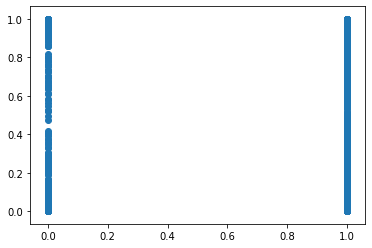

In [135]:
plt.scatter(y_val_norm[0:1].flatten(), preds_val[0:1].flatten())

In [133]:
y_val_norm = y_valid * 255
for i in np.arange(0.1, 1, 0.1):
    print(i, iou(y_val_norm, preds_val > i))

0.1 0.5844411186244791
0.2 0.5845477706006279
0.30000000000000004 0.5845966125008991
0.4 0.5846197490126986
0.5 0.5845555050896364
0.6 0.5844927057897266
0.7000000000000001 0.5844087241290714
0.8 0.5842964156616199
0.9 0.584015743183912


In [184]:
np.random.randint(0, 1, 5)

array([0, 0, 0, 0, 0])

In [139]:
iou((y_test * 255), preds_test_binary)

0.5930900540860007

In [192]:
base_case_iou = iou(y_test * 255, np.ones(y_test.shape[0] * split_dimension * split_dimension).reshape(y_test.shape[0], split_dimension, split_dimension, 1))
base_case_iou

0.07137123743693034

In [116]:
(y_valid * 255).max()

1.0

In [50]:
mask_path = "/home/greg/Documents/metis/satellite-image-classification/data/xview2/xview2_tier3/xBD/joplin-tornado/masks_resize1024_split128_bit255_float16/joplin-tornado_00000116_post_disaster_part_02.png"
y_mask_obj = Image.open(mask_path)
y_mask = np.array(y_mask_obj)




/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:348: UserWarning: No contour levels were found within the data range.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:356: UserWarning: No contour levels were found within the data range.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:361: UserWarning: No contour levels were found within the data range.


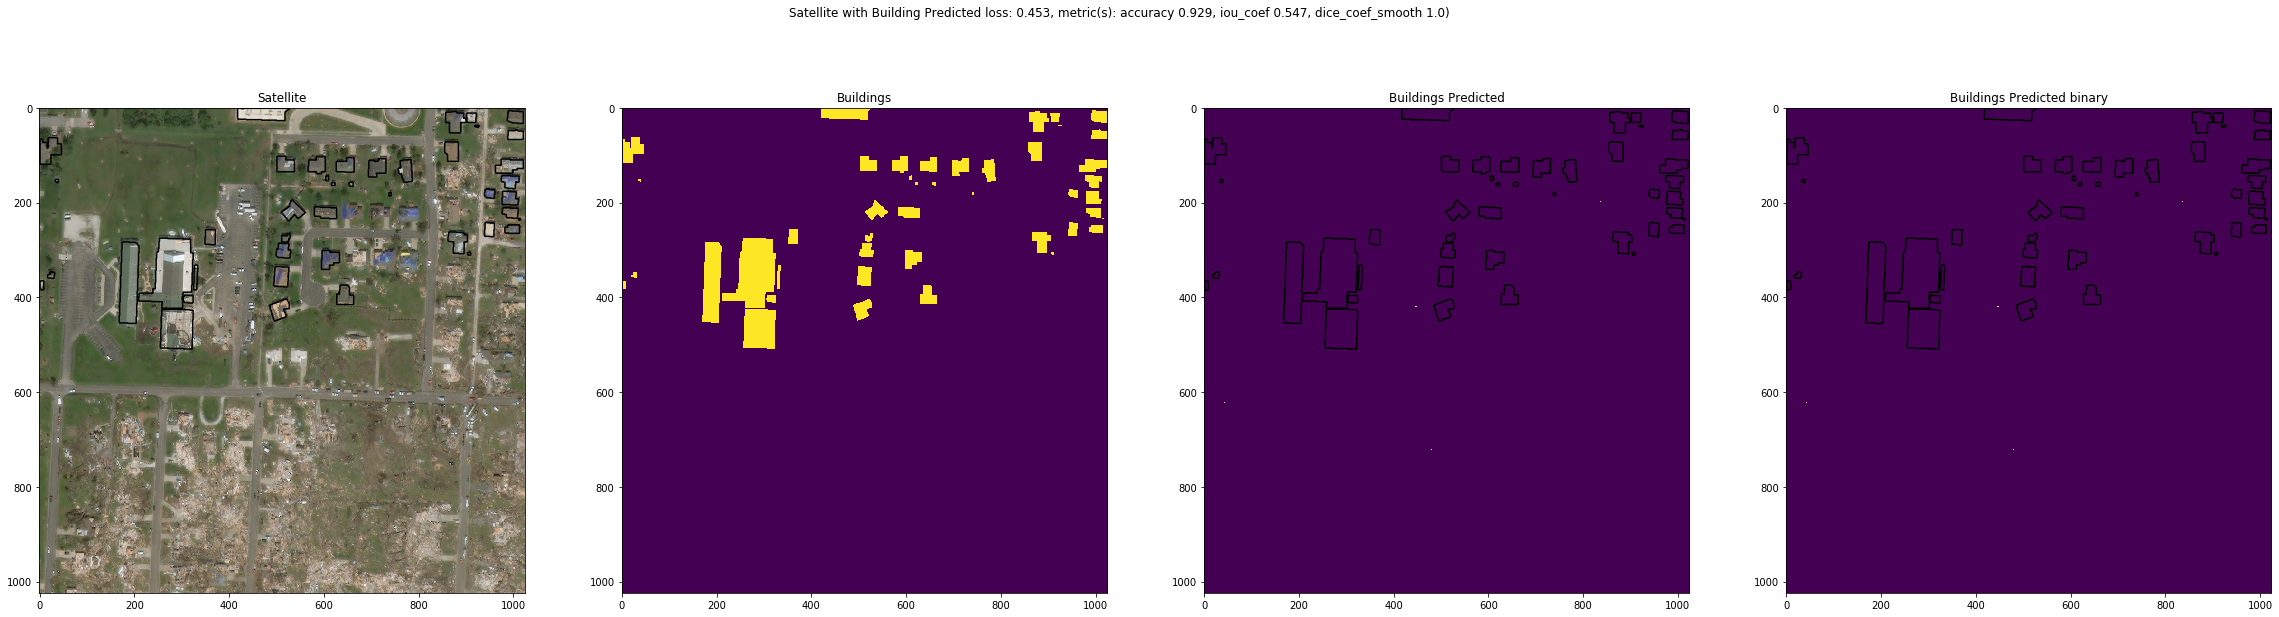

In [84]:
ix = 15
X = X_test
y = y_test
preds = preds_test
fig = plot_sample(
    model,
    X_test,
    y_test,
    preds_test * 1000000000000000,
    preds_test > 0.0000000000000001,
    evaluations['test'],
    15
)

In [71]:
ix = 15
start = ix * square_dim
end = start + square_dim

x_image = gldata.stich_images(X[start:end]).astype(np.float32)

y_image = gldata.stich_images(y[start:end]).astype(np.float32)

preds_image = gldata.stich_images(preds[start:end]).astype(np.float32)

binary_preds_image = gldata.stich_images(
    binary_preds[start:end]).astype(np.float32)


In [ ]:

binary_preds_image = gldata.stich_images(
    binary_preds[start:end]).astype(np.float32)


In [221]:
'_pre_' not in 'joploasd_pre_some'

False

In [230]:
assets_model_output_directory = "assets/xview2/_epochs80_train1_batch64_dropout0.1_n_filters16_metric-accuracy-iou-dice-smooth_loss-iou-coef-loss_float16/"
output_dir = "assets/xview2"
data_masks_joplin = "data/xview2/xview2_tier3/xBD/joplin-tornado/masks"
test_images = [
    (32, 'joplin-tornado_00000127'),
#     (20, 'joplin-tornado_00000121')
]

base_size = 1024 * 1024

pixels = []
for test_index, name in enumerate(ids_test):
    if '_post_' not in name:
        continue
    
    
    start = test_index * square_dim
    end = start + square_dim
    
    pre_mask_path = os.path.join(data_masks_joplin, f'{name}.png')
#     post_mask_path = os.path.join(data_masks_joplin, f'{name}.png') # not used?
    exists = os.path.exists(pre_mask_path) and os.path.exists(post_mask_path)
    
    if not exists:
        continue
    
    pre_mask_img = imread(pre_mask_path)
#     post_mask_img = imread(post_mask_path)
    predicted_mask_img = gldata.stich_images(preds_test_binary[start:end]).astype(np.float32)

    pre2g = rgb2gray(pre_mask_img)
    pred2g = predicted_mask_img.squeeze()
    
    pos_diff = ((pre2g - pred2g) > 0).astype(np.int)

    print(f'\n{name}')
    print('pos diff', pos_diff.shape, pos_diff.min(), pos_diff.max())
    
    original = np.sum(pre2g)
    destroyed = np.sum(pos_diff == 1)

    print('original', original, 'destroyed', destroyed)

    image_pre_event_pixels_percent = original / (1024 ** 2)
    image_post_event_pixels_percent = (original - destroyed) / (1024 ** 2)
    percentage_lost = (original - destroyed) / original


    img = gray2rgb(pos_diff*255)
    imgR = np.zeros((1024, 1024, 3))
    img[..., 1] = 0
    img[..., 2] = 0
    
    pixels.append((test_index, name, original, destroyed, percentage_lost))
    
    imsave(f'assets/xview2/differences/test_pred_fig_{test_index}_diff_{name}.png', img)

    imsave(f'assets/xview2/differences/test_pred_fig_{test_index}_pred_{name}.png', predicted_mask_img)

    imsave(f'assets/xview2/differences/test_pred_fig_{test_index}_pre_{name}.png', pre_mask_img)



Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000078_post_disaster
pos diff (1024, 1024) 0 1
original 44959.0 destroyed 12460


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_3_diff_joplin-tornado_00000137_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000137_post_disaster
pos diff (1024, 1024) 0 1
original 67236.0 destroyed 14815


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_4_diff_joplin-tornado_00000019_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000019_post_disaster
pos diff (1024, 1024) 0 1
original 18590.0 destroyed 8680

joplin-tornado_00000074_post_disaster
pos diff (1024, 1024) 0 1
original 110726.0 destroyed 50268


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_7_diff_joplin-tornado_00000074_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_9_diff_joplin-tornado_00000008_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaco


joplin-tornado_00000008_post_disaster
pos diff (1024, 1024) 0 1
original 10280.0 destroyed 3820

joplin-tornado_00000079_post_disaster
pos diff (1024, 1024) 0 1
original 170044.0 destroyed 63770


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_14_diff_joplin-tornado_00000077_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000077_post_disaster
pos diff (1024, 1024) 0 1
original 164859.0 destroyed 60229


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_15_diff_joplin-tornado_00000141_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000141_post_disaster
pos diff (1024, 1024) 0 1
original 50122.0 destroyed 28770

joplin-tornado_00000084_post_disaster
pos diff (1024, 1024) 0 1
original 3955.0 destroyed 1524


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_16_diff_joplin-tornado_00000084_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_16_pre_joplin-tornado_00000084_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_18_diff_joplin-tornado_00000054_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname


joplin-tornado_00000054_post_disaster
pos diff (1024, 1024) 0 1
original 78458.0 destroyed 46374

joplin-tornado_00000121_post_disaster
pos diff (1024, 1024) 0 1
original 21813.0 destroyed 9660


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_20_diff_joplin-tornado_00000121_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_22_diff_joplin-tornado_00000016_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000016_post_disaster
pos diff (1024, 1024) 0 1
original 25285.0 destroyed 8554

joplin-tornado_00000002_post_disaster
pos diff (1024, 1024) 0 1
original 58618.0 destroyed 20235


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_27_diff_joplin-tornado_00000002_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_29_diff_joplin-tornado_00000024_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/ana


joplin-tornado_00000024_post_disaster
pos diff (1024, 1024) 0 1
original 15454.0 destroyed 3613

joplin-tornado_00000035_post_disaster
pos diff (1024, 1024) 0 1
original 155542.0 destroyed 35226


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_32_diff_joplin-tornado_00000127_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_32_pre_joplin-tornado_00000127_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fi


joplin-tornado_00000127_post_disaster
pos diff (1024, 1024) 0 1
original 7709.0 destroyed 1173

joplin-tornado_00000037_post_disaster
pos diff (1024, 1024) 0 1
original 67787.0 destroyed 11932


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_37_diff_joplin-tornado_00000110_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000110_post_disaster
pos diff (1024, 1024) 0 1
original 81469.0 destroyed 17522


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_38_diff_joplin-tornado_00000009_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000009_post_disaster
pos diff (1024, 1024) 0 1
original 79040.0 destroyed 26148

joplin-tornado_00000003_post_disaster
pos diff (1024, 1024) 0 1
original 101244.0 destroyed 14895


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_43_diff_joplin-tornado_00000003_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_44_diff_joplin-tornado_00000129_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000129_post_disaster
pos diff (1024, 1024) 0 1
original 19281.0 destroyed 6644

joplin-tornado_00000030_post_disaster
pos diff (1024, 1024) 0 1
original 5579.0 destroyed 3805


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_45_diff_joplin-tornado_00000030_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_45_pre_joplin-tornado_00000030_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_48_diff_joplin-tornado_00000029_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname


joplin-tornado_00000029_post_disaster
pos diff (1024, 1024) 0 1
original 36623.0 destroyed 14601


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_50_diff_joplin-tornado_00000070_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_50_pred_joplin-tornado_00000070_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_53_diff_joplin-tornado_00000108_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fnam


joplin-tornado_00000070_post_disaster
pos diff (1024, 1024) 0 1
original 33506.0 destroyed 31189

joplin-tornado_00000108_post_disaster
pos diff (1024, 1024) 0 1
original 100146.0 destroyed 31260


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_55_diff_joplin-tornado_00000139_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000139_post_disaster
pos diff (1024, 1024) 0 1
original 61874.0 destroyed 12021


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_58_diff_joplin-tornado_00000122_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



joplin-tornado_00000122_post_disaster
pos diff (1024, 1024) 0 1
original 6971.0 destroyed 3943


/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/test_pred_fig_58_pre_joplin-tornado_00000122_post_disaster.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [231]:
worst_to_best = sorted(pixels, key=lambda item: item[3], reverse=True)
worst_to_best

[(12,
  'joplin-tornado_00000079_post_disaster',
  170044.0,
  63770,
  0.6249794170920467),
 (14,
  'joplin-tornado_00000077_post_disaster',
  164859.0,
  60229,
  0.6346635609824153),
 (7,
  'joplin-tornado_00000074_post_disaster',
  110726.0,
  50268,
  0.5460144862092011),
 (18,
  'joplin-tornado_00000054_post_disaster',
  78458.0,
  46374,
  0.40893216752912387),
 (31,
  'joplin-tornado_00000035_post_disaster',
  155542.0,
  35226,
  0.7735274073883581),
 (53,
  'joplin-tornado_00000108_post_disaster',
  100146.0,
  31260,
  0.6878557306332754),
 (50,
  'joplin-tornado_00000070_post_disaster',
  33506.0,
  31189,
  0.06915179370858951),
 (15,
  'joplin-tornado_00000141_post_disaster',
  50122.0,
  28770,
  0.4260005586369259),
 (38,
  'joplin-tornado_00000009_post_disaster',
  79040.0,
  26148,
  0.6691801619433199),
 (27,
  'joplin-tornado_00000002_post_disaster',
  58618.0,
  20235,
  0.6547988672421441),
 (37,
  'joplin-tornado_00000110_post_disaster',
  81469.0,
  17522,
  0.7

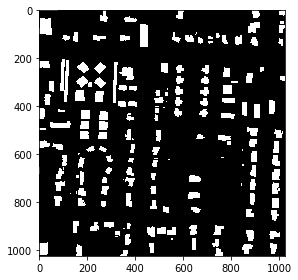

In [161]:
imshow(pre_mask_img)

In [162]:
pre_mask_img.shape

(1024, 1024, 3)

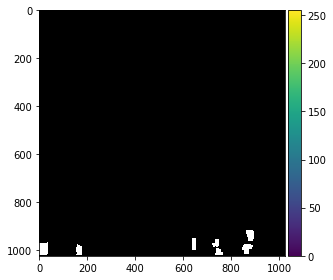

In [163]:
imshow(gray2rgb(post_mask_img))

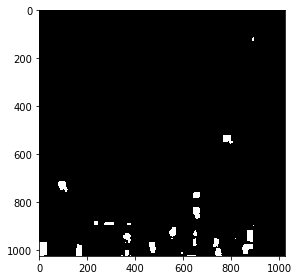

In [164]:
imshow(gray2rgb(predicted_mask_img.squeeze()))

Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


(1024, 1024) (1024, 1024) True True
(1024, 1024) 0 1
original 145827.0 destroyed 132991


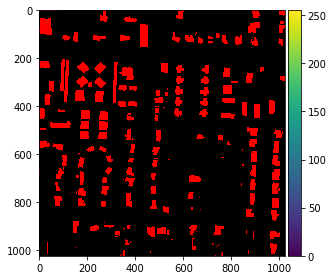

In [216]:
pre2g = rgb2gray(pre_mask_img)
pred2g = predicted_mask_img.squeeze()

print(pre2g.shape, pred2g.shape, pre2g.shape == pred2g.shape, pred2g.max() == pre2g.max())
pos_diff = ((pre2g - pred2g) > 0).astype(np.int)

print(pos_diff.shape, pos_diff.min(), pos_diff.max())
original = np.sum(pre2g)
destroyed = np.sum(pos_diff == 1)

print('original', original, 'destroyed', destroyed)

image_pre_event_pixels_percent = original / (1024 ** 2)
image_post_event_pixels_percent = (original - destroyed) / (1024 ** 2)


img = gray2rgb(pos_diff*255)
imgR = np.zeros((1024, 1024, 3))
img[..., 1] = 0
img[..., 2] = 0

imshow(img)

imsave('assets/xview2/differences/img.png', img)

In [177]:
pos_diff = ((pre2g - pred2g) > 0).astype(np.int)

In [180]:
print(pos_diff.shape, pos_diff.min(), pos_diff.max())

(1024, 1024) 0 1


In [182]:
1024 * 1024

1048576

In [193]:
original = np.sum(pre2g)
destroyed = np.sum(pos_diff == 1)
print('ori')

In [198]:
original / (1024 ** 2)

0.13907146453857422

In [199]:
destroyed / (1024 ** 2)

0.1268301010131836

In [201]:
(original - destroyed) / (1024 ** 2)

0.012241363525390625

In [197]:
(original - destroyed) / original

0.08802210838870717

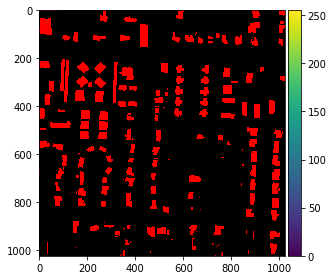

In [213]:
img = gray2rgb(pos_diff*255)
imgR = np.zeros((1024, 1024, 3))
img[..., 1] = 0
img[..., 2] = 0

imshow(img)

In [215]:
imsave('assets/xview2/differences/img.png', img)

/home/greg/anaconda3/envs/metis/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: assets/xview2/differences/img.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
